<a href="https://colab.research.google.com/github/xAn-x/Malaria-Classification/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Load Dataset

In [ ]:
dataset,info=tfds.load("malaria",with_info=True,as_supervised=True,download=True)

``Save Model in G-Drive so u don't have to download it again again again as collab shuts-off ater sometime``

```**** Change to CODE-Cell if running notebook for first time,till last marked cell *****```

```python
from google.colab import drive
drive.mount('/content/drive')
```

```python
!cp -r /root/tensorflow_datasets/malaria /content/drive/MyDrive/
```

```python
# Copy Malaria Dataset to Google Drive
!cp -r /root/tensorflow_datasets/malaria /content/drive/MyDrive/
```

In [ ]:
# Set the path to the Malaria dataset in your Google Drive
dataset_path = '/content/drive/MyDrive/'

# Load the Malaria dataset using TensorFlow Datasets
dataset, info = tfds.load('malaria', data_dir=dataset_path, with_info=True,as_supervised=True,download=False)

```**** Till HERE ******```

In [ ]:
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/content/drive/MyDrive/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear image

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

## Train Test Split

In [ ]:
def split(dataset,train_ratio=0.7,val_ratio=0.2,test_ratio=0.1):
    size_of_dataset=len(dataset)
    train_size=int(size_of_dataset*train_ratio)
    val_size=int(size_of_dataset*val_ratio)
    test_size=int(size_of_dataset*test_ratio)

    train_dataset=dataset.take(train_size)
    val_dataset=dataset.skip(train_size).take(val_size)
    test_dataset=dataset.skip(train_size+val_size).take(test_size)

    return train_dataset,val_dataset,test_dataset

In [ ]:
train_dataset,val_dataset,test_dataset=split(dataset["train"])

In [ ]:
print(f"The length of the training dataset is {len(dataset['train'])}.")
print(f"The length of the validation dataset is {len(train_dataset)}.")
print(f"The length of the validation dataset is {len(val_dataset)}.")
print(f"The length of the test dataset is {len(test_dataset)}.")

The length of the training dataset is 27558.
The length of the validation dataset is 19290.
The length of the validation dataset is 5511.
The length of the test dataset is 2755.


## Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def visualize_dataset(dataset, n=12,rows=3,cols=4):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8))
  r,c=0,0
  for i, (image, label) in enumerate(dataset.take(n)):
    axes[r, c].imshow(image)
    axes[r, c].set_title(label.numpy())
    axes[r, c].set_axis_off()

    c+=1
    if c==cols:
      r,c=r+1,0
  plt.show()


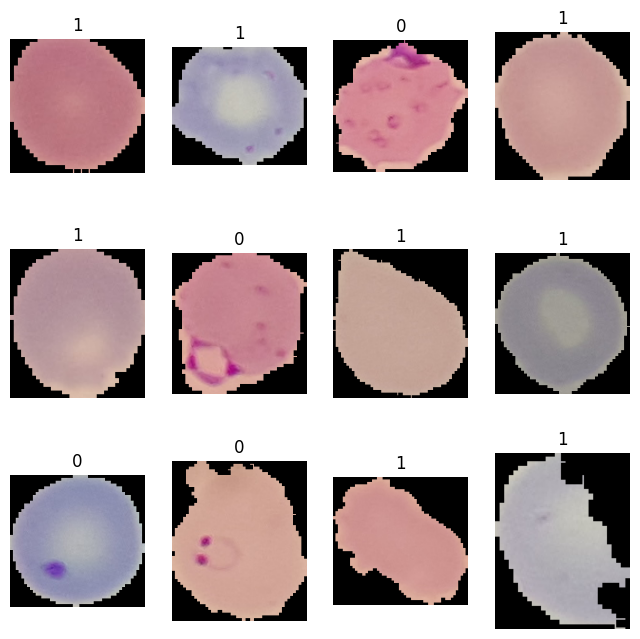

In [ ]:
visualize_dataset(train_dataset)

In [ ]:
# checking size of images
for i,(image,label) in enumerate(train_dataset.take(5)):
  print(f"size of img {i+1}:{image.shape}")

size of img 1:(103, 103, 3)
size of img 2:(106, 121, 3)
size of img 3:(139, 142, 3)
size of img 4:(130, 118, 3)
size of img 5:(121, 109, 3)


## Preprocessing Datasets

In [ ]:
IMG_SIZE=120
def resize_and_normalize(image,label):
  image=tf.cast(image,tf.float16)
  label=tf.cast(label,tf.float16)

  image=tf.image.resize(image/255.,(IMG_SIZE,IMG_SIZE))

  return image,label

In [ ]:
train_ds=train_dataset.map(resize_and_normalize,num_parallel_calls=4)
val_ds=val_dataset.map(resize_and_normalize,num_parallel_calls=4)
test_ds=test_dataset.map(resize_and_normalize,num_parallel_calls=4)

In [ ]:
# checking size of images
for i,(image,label) in enumerate(train_ds.take(5)):
  print(f"size of img {i+1}:{image.shape}")

size of img 1:(120, 120, 3)
size of img 2:(120, 120, 3)
size of img 3:(120, 120, 3)
size of img 4:(120, 120, 3)
size of img 5:(120, 120, 3)


In [ ]:
# function to divide a dataset in batches ,no of epochs,shuffle if true

def preprocess_dataset(dataset, batch_size,epochs=1,shuffle=True):
  if shuffle:
    dataset = dataset.shuffle(buffer_size=1024)
  dataset = dataset.batch(batch_size).prefetch(1024)
  return dataset

In [ ]:
BATCH_SIZE=32
EPOCHS=2

train_ds = preprocess_dataset(train_ds, batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True)
val_ds = preprocess_dataset(val_ds, batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True)
test_ds = preprocess_dataset(test_ds, batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=False)

In [ ]:
# prompt: print shape for each of ds

print(f"shape of train dataset is {train_ds.element_spec}")
print(f"shape of val dataset is {val_ds.element_spec}")
print(f"shape of test dataset is {test_ds.element_spec}")

shape of train dataset is (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float16, name=None))
shape of val dataset is (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float16, name=None))
shape of test dataset is (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float16, name=None))


## Model Creation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 28, 28, 128)       512       
 Normalization)                                                  
                                                        

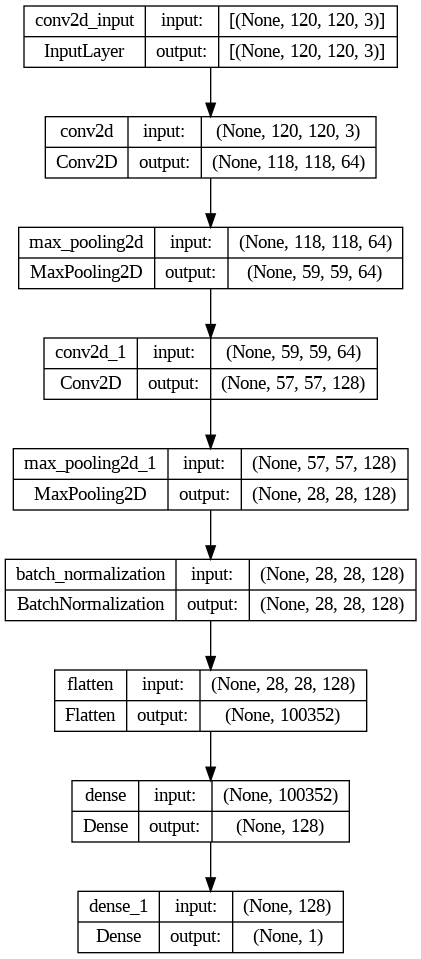

In [ ]:
# plot the model with input shape
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# A early stopping call back measuring val_accuraccy and min_delta=0.05
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001,patience=3)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds,epochs=5,callbacks=[early_stopping])

Epoch 1/5
603/603 [==============================] - 56s 73ms/step - loss: 0.6427 - accuracy: 0.7393 - val_loss: 1.1339 - val_accuracy: 0.4914
Epoch 2/5
603/603 [==============================] - 50s 79ms/step - loss: 0.2844 - accuracy: 0.9055 - val_loss: 0.4894 - val_accuracy: 0.7826
Epoch 3/5
603/603 [==============================] - 47s 76ms/step - loss: 0.2109 - accuracy: 0.9298 - val_loss: 0.2340 - val_accuracy: 0.9303
Epoch 4/5
603/603 [==============================] - 46s 75ms/step - loss: 0.1377 - accuracy: 0.9544 - val_loss: 0.2516 - val_accuracy: 0.9142
Epoch 5/5
603/603 [==============================] - 48s 79ms/step - loss: 0.0712 - accuracy: 0.9764 - val_loss: 0.2582 - val_accuracy: 0.9323


In [ ]:
def visulaize_metric(history,metric):
  plt.plot(history.history[metric], label=metric)
  plt.plot(history.history['val_'+metric], label='val_'+metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

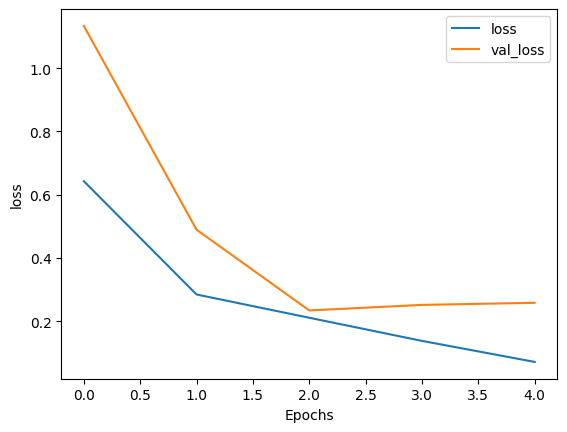

In [ ]:
visulaize_metric(history,"loss")

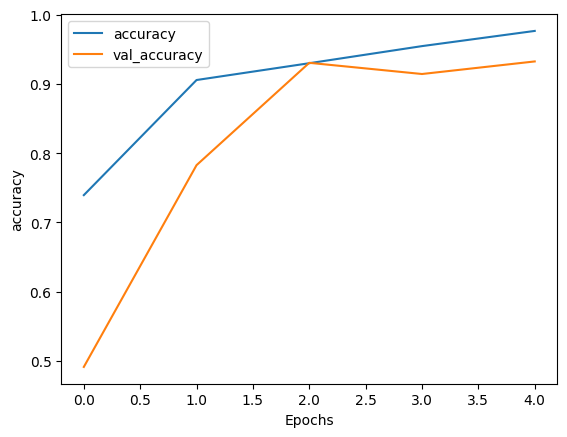

In [ ]:
visulaize_metric(history,"accuracy")

## Evaluating over test_ds

In [ ]:
model.evaluate(test_ds)

87/87 [==============================] - 16s 35ms/step - loss: 0.2487 - accuracy: 0.9321


[0.24873565137386322, 0.9321234226226807]

## Save Model

In [ ]:
# save Model wts and architechture
model.save("malaria_model.keras")

In [ ]:
# Load Model
model=tf.keras.models.load_model("malaria_model.keras")